# Description
Welcome to Prostate cANcer graDe Assessment (PANDA) Challenge. The task of this competition is classification of images with cancer tissue. The main challenge of this task is dealing with images of extremely high resolution and large areas of empty space. So, effective locating the areas of concern and zooming them in would be the key to reach high LB score.

In this competition I found a number of public kernels performing straightforward rescaling the input images to square. However, for this particular data such an approach is not very efficient because the aspect ratio and size of provided images are not consistent and vary in a wide range. As a result, the input images are deformed to large extend in a not consistent manner uppon rescaling that limits the ability of the model to learn. Moreover, the input consists of large empty areas leading to inefficient use of GPU memory and GPU time.

In this kernel I propose an alternative approach based on **Concatenate Tile pooling**. Instead of passing an entire image as an input, N tiles are selected from each image based on the number of tissue pixels (see [this kernel](https://www.kaggle.com/iafoss/panda-16x128x128-tiles) for description of data preparation and the [corresponding dataset](https://www.kaggle.com/iafoss/panda-16x128x128-tiles-data)) and passed independently through the convolutional part. The outputs of the convolutional part is concatenated in a large single map for each image preceding pooling and FC head (see image below). Since any spatial information is eliminated by the pooling layer, the Concat Tile pooling approach is nearly identical to passing an entire image through the convolutional part, excluding predictions for nearly empty regions, which do not contribute to the final prediction, and shuffle the remaining outputs into a square map of smaller size. Below I provide just a basic kernel only illustrating this approach. In my first trial I got 0.76 LB score, top 2 at the moment, and I believe it could be easily boosted to 0.80+. I hope you would enjoy my kernel, and please also check my submission kernel implementing the tile based approach.

![](https://i.ibb.co/hF6LRVm/TILE.png)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
import os
#from sklearn.model_selection import KFold
from radam import *
from csvlogger import *
from mish_activation import *
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score,confusion_matrix
import warnings
warnings.filterwarnings("ignore")

fastai.__version__

'1.0.60'

In [2]:
# remove this cell if run locally
!mkdir 'cache'
!mkdir 'cache/torch'
!mkdir 'cache/torch/checkpoints'
!cp '../input/pytorch-pretrained-models/semi_supervised_resnext50_32x4-ddb3e555.pth' 'cache/torch/checkpoints/'
torch.hub.DEFAULT_CACHE_DIR = 'cache'

In [3]:
sz = 128
bs = 32
nfolds = 4
SEED = 2020
N = 12 #number of tiles per image
TRAIN = '../input/panda-16x128x128-tiles-data/train/'
LABELS = '../input/prostate-cancer-grade-assessment/train.csv'

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# Data

Use stratified KFold split.

In [5]:
df = pd.read_csv(LABELS).set_index('image_id')
files = sorted(set([p[:32] for p in os.listdir(TRAIN)]))
df = df.loc[files]
df = df.reset_index()
splits = StratifiedKFold(n_splits=nfolds, random_state=SEED, shuffle=True)
splits = list(splits.split(df,df.isup_grade))
folds_splits = np.zeros(len(df)).astype(np.int)
for i in range(nfolds): folds_splits[splits[i][1]] = i
df['split'] = folds_splits
df.head()

,image_id,data_provider,isup_grade,gleason_score,split
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,1
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,0
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,0
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,1


Check [this kernel](https://www.kaggle.com/iafoss/panda-16x128x128-tiles) for image stats. Since I use zero padding and background corresponds to 255, I invert images as 255-img when load them. Therefore, the mean value is computed as '1 - val'.

In [6]:
mean = torch.tensor([1.0-0.90949707, 1.0-0.8188697, 1.0-0.87795304])
std = torch.tensor([0.36357649, 0.49984502, 0.40477625])

The code below (in the hidden cell) creates ImageItemList capable of loading multiple tiles of an image. It is specific for fast.ai, and pure Pytorch code would be much simpler.

In [7]:
def open_image(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', cls:type=Image,
        after_open:Callable=None)->Image:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        x = PIL.Image.open(fn).convert(convert_mode)
    if after_open: x = after_open(x)
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return cls(1.0-x) #invert image for zero padding

class MImage(ItemBase):
    def __init__(self, imgs):
        self.obj, self.data = \
          (imgs), [(imgs[i].data - mean[...,None,None])/std[...,None,None] for i in range(len(imgs))]
    
    def apply_tfms(self, tfms,*args, **kwargs):
        for i in range(len(self.obj)):
            self.obj[i] = self.obj[i].apply_tfms(tfms, *args, **kwargs)
            self.data[i] = (self.obj[i].data - mean[...,None,None])/std[...,None,None]
        return self
    
    def __repr__(self): return f'{self.__class__.__name__} {img.shape for img in self.obj}'
    def to_one(self):
        img = torch.stack(self.data,1)
        img = img.view(3,-1,N,sz,sz).permute(0,1,3,2,4).contiguous().view(3,-1,sz*N)
        return Image(1.0 - (mean[...,None,None]+img*std[...,None,None]))

class MImageItemList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def __len__(self)->int: return len(self.items) or 1 
    
    def get(self, i):
        fn = Path(self.items[i])
        fnames = [Path(str(fn)+'_'+str(i)+'.png')for i in range(N)]
        imgs = [open_image(fname, convert_mode=self.convert_mode, after_open=self.after_open)
               for fname in fnames]
        return MImage(imgs)

    def reconstruct(self, t):
        return MImage([mean[...,None,None]+_t*std[...,None,None] for _t in t])
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(300,50), **kwargs):
        rows = min(len(xs),8)
        fig, axs = plt.subplots(rows,1,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()
        

#collate function to combine multiple images into one tensor
def MImage_collate(batch:ItemsList)->Tensor:
    result = torch.utils.data.dataloader.default_collate(to_data(batch))
    if isinstance(result[0],list):
        result = [torch.stack(result[0],1),result[1]]
    return result

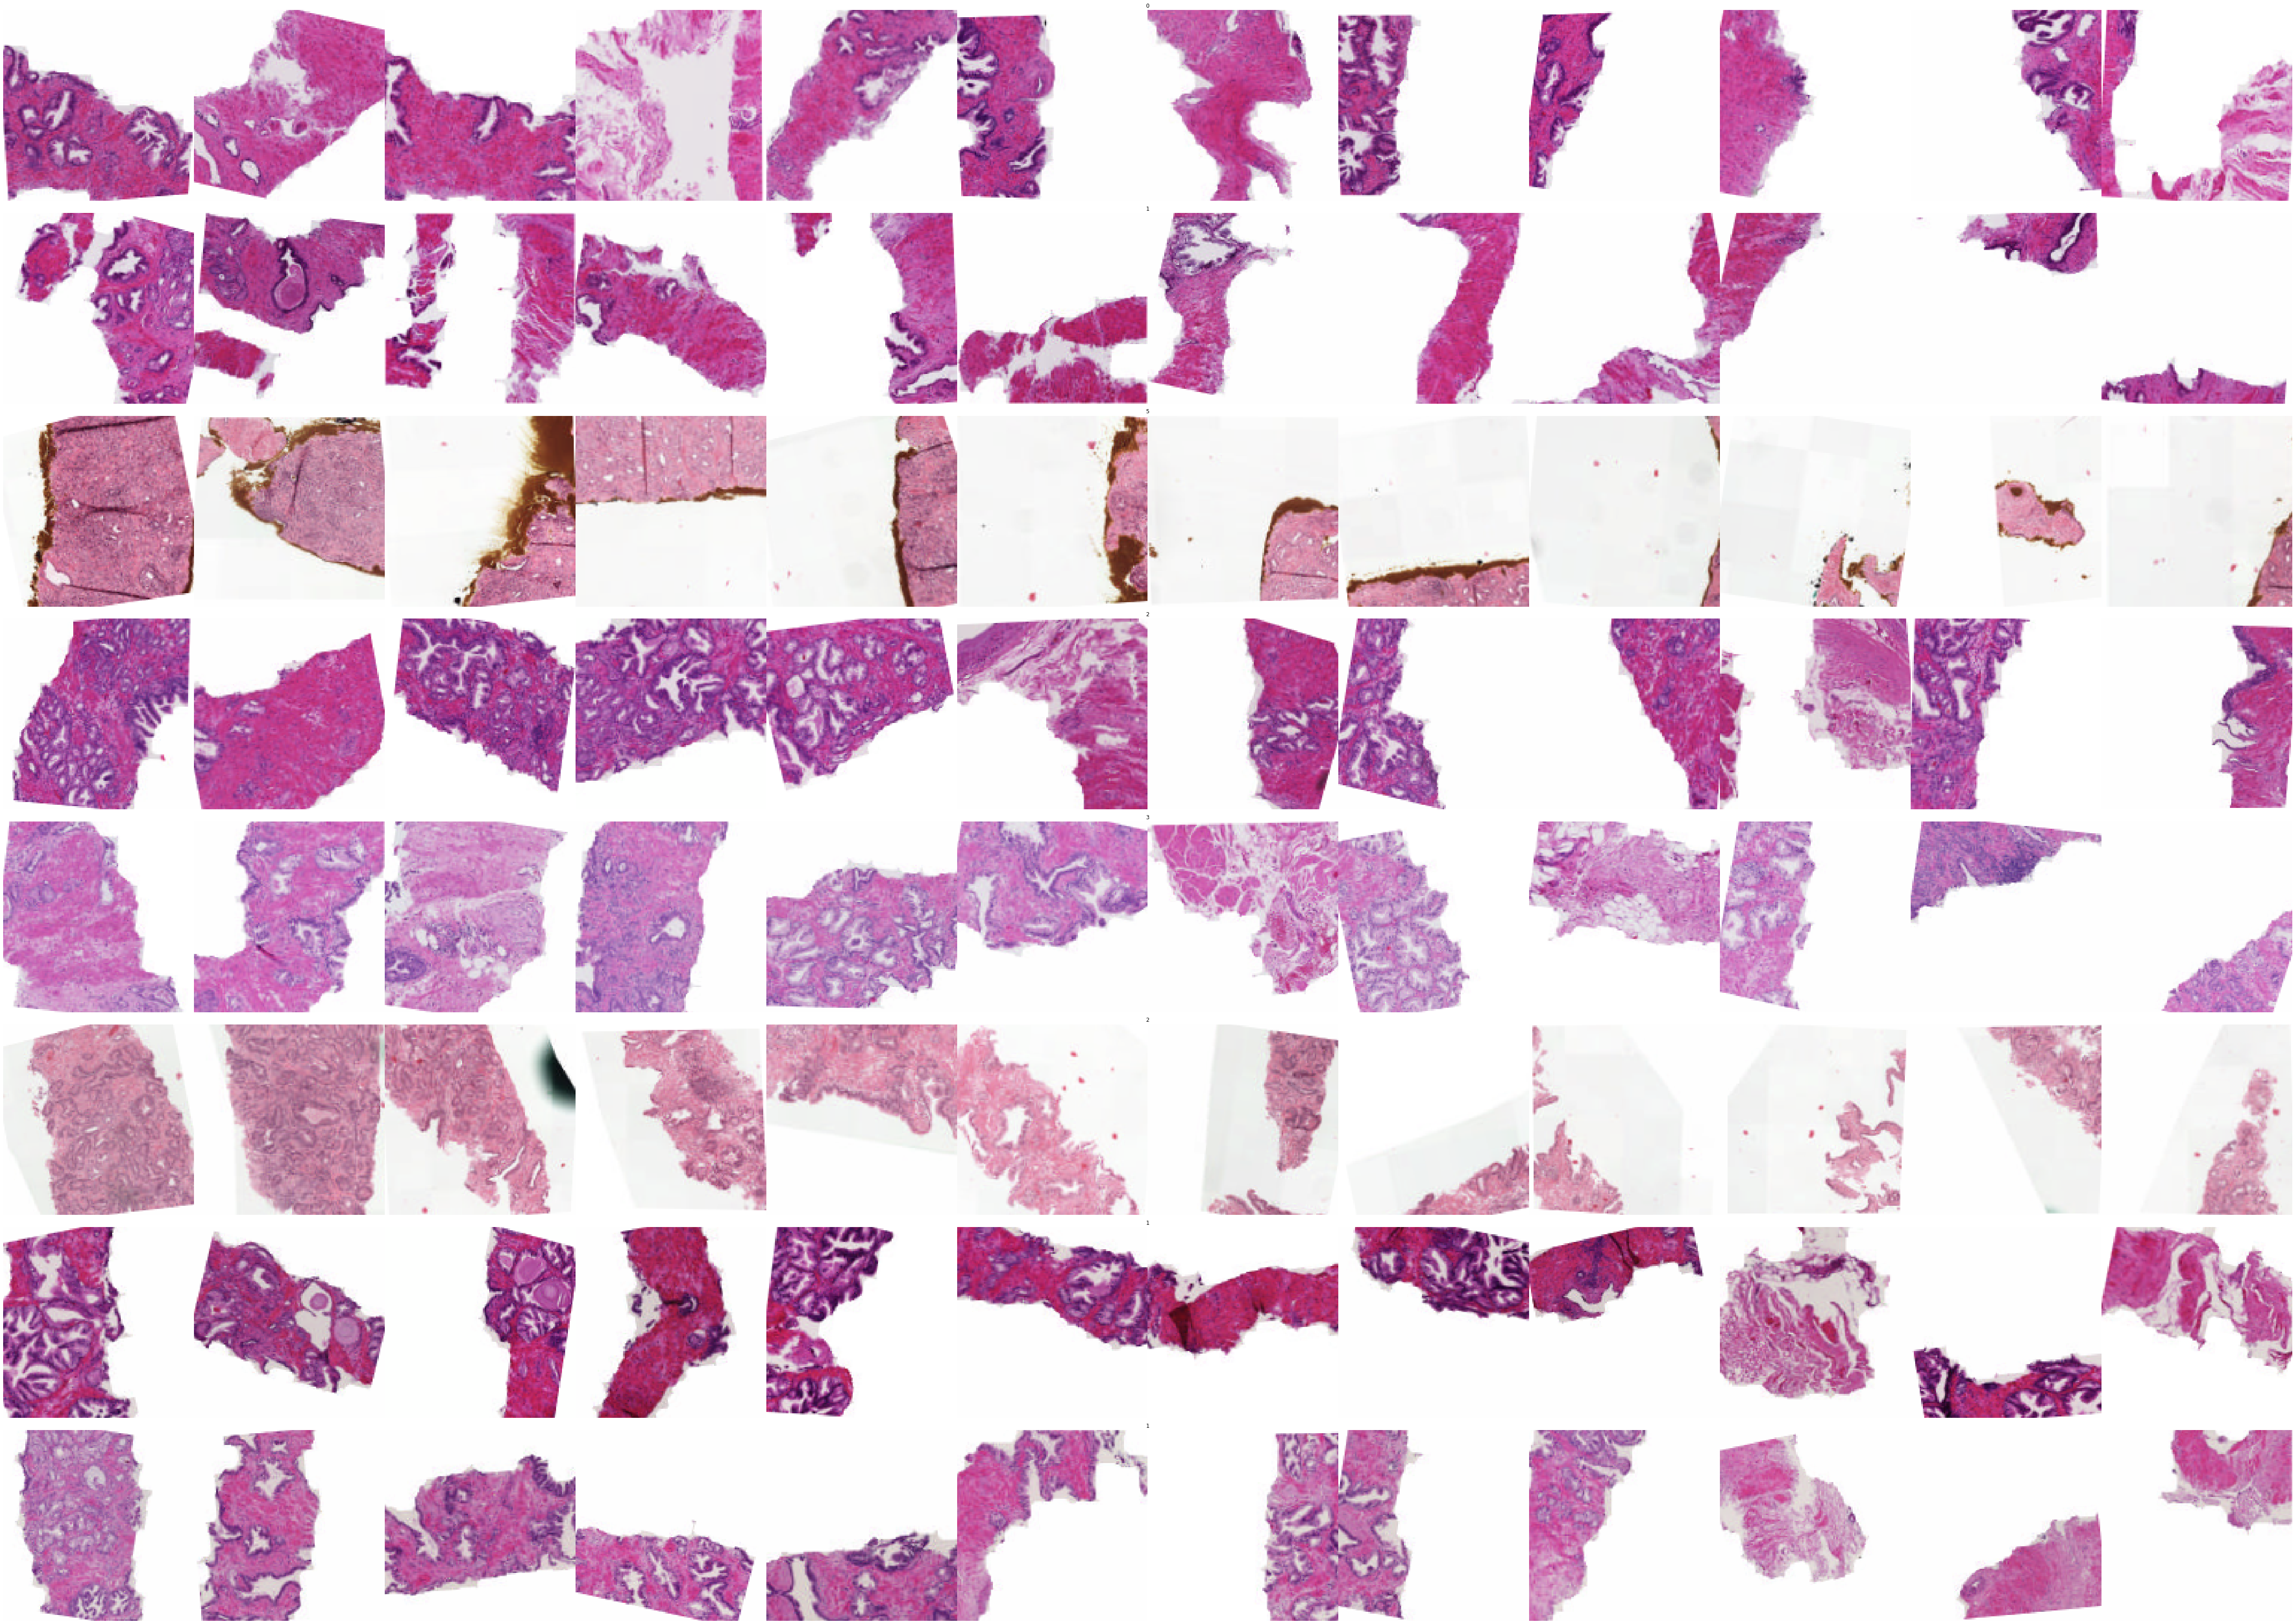

In [8]:
def get_data(fold=0):
    return (MImageItemList.from_df(df, path='.', folder=TRAIN, cols='image_id')
      .split_by_idx(df.index[df.split == fold].tolist())
      .label_from_df(cols=['isup_grade'])
      .transform(get_transforms(
          do_flip=True,  # general flip
          flip_vert=True,  # vertical flip
          max_rotate=15,  # maximum rotation of 15 degrees
          max_zoom=1.1,  # zoom in/out up to 10%
          max_lighting=0.1,  # slight adjustments to brightness and contrast
          max_warp=0.1,  # slight perspective warp
          p_affine=0.75,  # probability of applying affine transformations
          p_lighting=0.75,  # probability of applying lighting transformations
      ), size=sz, padding_mode='zeros')
      .databunch(bs=bs,num_workers=4))

data = get_data(0)
data.show_batch()

# Model

The code below implements Concat Tile pooling idea. As a backbone I use [Semi-Weakly Supervised ImageNet pretrained ResNeXt50 model](https://github.com/facebookresearch/semi-supervised-ImageNet1K-models), which worked for me quite well in a number of previous competitions.

In [9]:
class Model(nn.Module):
    def __init__(self, arch='resnext50_32x4d_ssl', n=6, pre=True):
        super().__init__()
        m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', arch)
        self.enc = nn.Sequential(*list(m.children())[:-2])       
        nc = list(m.children())[-1].in_features
        self.head = nn.Sequential(AdaptiveConcatPool2d(),Flatten(),nn.Linear(2*nc,512),
                            Mish(),nn.BatchNorm1d(512), nn.Dropout(0.5),nn.Linear(512,n))
        
    def forward(self, *x):
        shape = x[0].shape
        n = len(x)
        x = torch.stack(x,1).view(-1,shape[1],shape[2],shape[3])
        #x: bs*N x 3 x 128 x 128
        x = self.enc(x)
        #x: bs*N x C x 4 x 4
        shape = x.shape
        #concatenate the output for tiles into a single map
        x = x.view(-1,n,shape[1],shape[2],shape[3]).permute(0,2,1,3,4).contiguous()\
          .view(-1,shape[1],shape[2]*n,shape[3])
        #x: bs x C x N*4 x 4
        x = self.head(x)
        #x: bs x n
        return x

# Training

In [10]:
fname = 'RNXT50'
pred,target = [],[]
for fold in range(nfolds):
    data = get_data(fold)
    model = Model()
    learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), opt_func=Over9000, 
                metrics=[KappaScore(weights='quadratic')]).to_fp16()
    logger = CSVLogger(learn, f'log_{fname}_{fold}')
    learn.clip_grad = 1.0
    learn.split([model.head])
    learn.unfreeze()

    learn.fit_one_cycle(16, max_lr=1e-3, div_factor=100, pct_start=0.0, 
      callbacks = [SaveModelCallback(learn,name=f'model',monitor='kappa_score')])
    torch.save(learn.model.state_dict(), f'{fname}_{fold}.pth')
    
    learn.model.eval()
    with torch.no_grad():
        for step, (x, y) in progress_bar(enumerate(data.dl(DatasetType.Valid)),
                                     total=len(data.dl(DatasetType.Valid))):
            p = learn.model(*x)
            pred.append(p.float().cpu())
            target.append(y.cpu())

Downloading: "https://github.com/facebookresearch/semi-supervised-ImageNet1K-models/archive/master.zip" to cache/torch/hub/master.zip


epoch,train_loss,valid_loss,kappa_score,time
0,1.373102,1.638286,0.594643,08:21
1,1.245871,1.452302,0.663513,04:49
2,1.180127,1.679751,0.626767,04:47
3,1.104310,1.576319,0.654950,04:49
4,1.096048,1.282735,0.713498,04:48
5,1.065992,1.107236,0.730414,04:46
6,1.057057,1.415427,0.707000,04:48
7,0.992066,1.276606,0.727412,04:48
8,0.952869,1.308190,0.724149,04:50
9,0.934314,1.413962,0.719302,04:51


Better model found at epoch 0 with kappa_score value: 0.5946429967880249.
Better model found at epoch 1 with kappa_score value: 0.6635133028030396.
Better model found at epoch 4 with kappa_score value: 0.7134977579116821.
Better model found at epoch 5 with kappa_score value: 0.7304137945175171.
Better model found at epoch 11 with kappa_score value: 0.7413051724433899.
Better model found at epoch 12 with kappa_score value: 0.7706561088562012.
Better model found at epoch 14 with kappa_score value: 0.7726262807846069.


Using cache found in cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


epoch,train_loss,valid_loss,kappa_score,time
0,1.360355,1.749630,0.569628,04:49
1,1.256447,1.264816,0.693861,04:48
2,1.189312,1.301736,0.710918,04:49
3,1.126708,1.328718,0.702859,04:48
4,1.074936,1.179773,0.712845,04:48
5,1.078724,1.359746,0.645091,04:48
6,1.034112,1.475732,0.613643,04:47
7,0.990679,1.510623,0.689948,04:47
8,0.953164,1.221176,0.705818,04:45
9,0.896925,1.449243,0.713783,04:44


Better model found at epoch 0 with kappa_score value: 0.5696284770965576.
Better model found at epoch 1 with kappa_score value: 0.6938608884811401.
Better model found at epoch 2 with kappa_score value: 0.7109184265136719.
Better model found at epoch 4 with kappa_score value: 0.7128452062606812.
Better model found at epoch 9 with kappa_score value: 0.7137826085090637.
Better model found at epoch 13 with kappa_score value: 0.7219443321228027.


Using cache found in cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


epoch,train_loss,valid_loss,kappa_score,time
0,1.374260,1.699329,0.621066,04:42
1,1.224519,1.507130,0.615975,04:43
2,1.191138,1.509972,0.620900,04:43
3,1.132245,1.468167,0.674377,04:43
4,1.128912,1.297951,0.709424,04:44
5,1.088186,1.302371,0.696760,04:44
6,1.014055,2.048477,0.545876,04:46
7,1.009601,1.539015,0.666403,04:46
8,0.943864,1.305500,0.719646,04:47
9,0.914257,1.567694,0.686294,04:47


Better model found at epoch 0 with kappa_score value: 0.6210658550262451.
Better model found at epoch 3 with kappa_score value: 0.6743768453598022.
Better model found at epoch 4 with kappa_score value: 0.7094235420227051.
Better model found at epoch 8 with kappa_score value: 0.7196464538574219.


Using cache found in cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


epoch,train_loss,valid_loss,kappa_score,time
0,1.367628,1.553532,0.610989,04:45
1,1.265316,1.522877,0.649956,04:47
2,1.189381,1.150451,0.740265,04:43
3,1.131325,1.493119,0.656880,04:42
4,1.102116,1.417908,0.695703,04:42
5,1.078939,1.330693,0.642601,04:43
6,1.040904,1.517968,0.681355,04:43
7,1.023058,1.307722,0.687645,04:43
8,0.965109,1.221961,0.731064,04:44
9,0.919550,1.322945,0.713156,04:47


Better model found at epoch 0 with kappa_score value: 0.6109890937805176.
Better model found at epoch 1 with kappa_score value: 0.6499556303024292.
Better model found at epoch 2 with kappa_score value: 0.7402654886245728.
Better model found at epoch 12 with kappa_score value: 0.7489684820175171.


In [11]:
p = torch.argmax(torch.cat(pred,0),1)
t = torch.cat(target)
print(cohen_kappa_score(t,p,weights='quadratic'))
print(confusion_matrix(t,p))

0.740189573031433
[[2514  241    8   19   33   58]
 [ 529 1462  241  114  155  115]
 [ 102  306  298  210  176  249]
 [  78   80   41  206  252  569]
 [ 111   60   20   48  471  535]
 [  76   11    6   10  116  996]]


In [12]:
!rm -r 'cache'